# Data Scientist Technical Test Nubalu.

## Análisis y preprocesamiento.

En primer lugar, es necesario cargar todas las librerías que se usaran a lo largo de este Notebook.

In [1]:
#Gestión de datos
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#Métricas
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.metrics import mean_squared_error as mse

#Selección de características
from sklearn.feature_selection import RFE

#Modelos
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

### Lectura y visualización de la base de datos

Mediante Pandas, cargamos los datos almacenados en un CSV (comma-separated values) en un dataframe.

In [2]:
data = pd.read_csv("dataset.csv")

Una vez tenemos el dataframe con los datos correctamente cargados, es muy necesario comprobar si existe algún dato incompleto o faltante.

In [3]:
data.isna().sum()

property_transactions    0
mortgages_amount         0
consumer_price_index     0
gross_income             0
unemployment_rate        0
construction_workers     0
property_price_index     0
dtype: int64

Con estos resultados estamos seguros de que los datos están completos y no faltan valores en todo el dataframe. A continuación podemos ver un breve análisis del dominio y la distribución de los datos.

In [4]:
data.describe()

,property_transactions,mortgages_amount,consumer_price_index,gross_income,unemployment_rate,construction_workers,property_price_index
count,50.00000,5.000000e+01,50.000000,5.000000e+01,50.000000,5.000000e+01,50.000000
mean,64052.32000,4.704341e+09,98.116480,2.673742e+11,18.820600,1.480714e+06,119.249500
std,20516.65798,3.799715e+09,4.543268,1.622420e+10,5.294338,5.609719e+05,18.539357
min,39824.00000,1.252198e+09,87.747000,2.495220e+11,7.930000,9.725000e+05,95.208000
25%,48369.75000,2.300314e+09,93.931250,2.560105e+11,15.555000,1.078450e+06,102.979500
50%,60683.00000,3.325462e+09,99.850000,2.612280e+11,19.715000,1.218600e+06,116.467500
75%,71777.25000,6.309909e+09,101.278750,2.745838e+11,23.392500,1.694675e+06,135.891250
max,138804.00000,1.714641e+10,104.824000,3.088850e+11,26.940000,2.761700e+06,151.719000


En esta gráfica se puede observar que existen 50 instancias en este Dataset compuestas por 7 características numéricas con valores continuos. Podemos adelantar que 50 instancias realmente constituyen un Dataset algo limitado en información y que, por tanto, podría afectar a las decisiones que se tomen a lo largo de este análisis.

Para analizar cada una de estas características debemos fijarnos principalmente en la media y la desviación típica, así como en los cuartiles y analizar si a simple vista existe algún valor fuera de lo común, como, por ejemplo, valores extremos o cuartiles extrañamente repartidos a lo largo del dominio de la variable. 

El problema a analizar consta de las siguientes variables de entrada:

In [5]:
print (data.columns[:-1].values)

['property_transactions' 'mortgages_amount' 'consumer_price_index'
 'gross_income' 'unemployment_rate' 'construction_workers']


A través de estas variables de entrada debemos estimar la varable de salida:

In [6]:
print (data.columns[-1])

property_price_index


Para algunos de los métodos que vamos a aplicar en este dataset puede ser necesario que los datos estén normalizados, así que se va a definir esta función para usarla cuando sea necesaria.

In [7]:
def normalice(data):
    names = data.columns
    x = data.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled)
    data.columns = names
    return data

#### Relación lineal entre las diferentes características

Para analizar la importancia que las variables de entrada pueden tener en los futuros modelos aplicados, podemos calcular una matriz de correlación y ver la dependencia lineal entre las diferentes características.

La matriz de correlación calculada es la siguiente:

(7.0, 0.0)

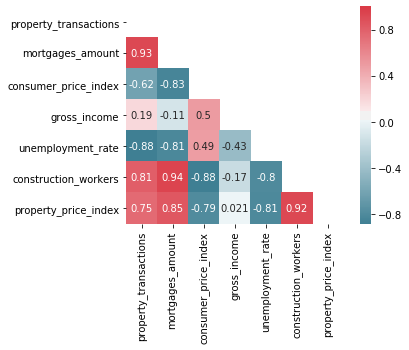

In [8]:
# Se genera la matriz de correlación
corrM = data.corr()

# Se genera una máscara para el triangulo superior
mask = np.zeros_like(corrM, dtype=np.bool)
mask[np.triu_indices_from(mask)] = 1

# Creamos un mapa de color personalizado 
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Pintamos el gráfico de la matriz
ax = sns.heatmap(corrM, 
            mask=mask,
            annot=True,
            square=True,
            cmap=cmap)
bottom, top = ax.get_ylim()

#Ajuste necesario para que salga la gráfica completa
ax.set_ylim(bottom + 0.5, top - 0.5)

En esté gráfico, los valores cercanos a cero quieren decir que su correlación lineal es escasa o nula, mientras que los valores cercanos a 1 o -1 indicas alta relación positiva o negativa, respectivamente.

Con este análisis buscamos encontrar y conservar aquellas características de entrada con una alta relación con la variable de salida y descartar aquellas que tengan una poca relación. Al mismo tiempo, las variables de entrada con una alta relación entre ellas (mayor al 80%), también deberán ser eliminadas, ya que pueden constituir información redundante y confundir a los modelos utilizados.

De este matriz podemos sacar algunas conclusiones.

- La variable "gross_income" apenas tiene relación con la variable de salida "property_price_index".
- Las variables "property_transactions", "mortgages_amount" y "construction_workers" tienen una alta correlación lineal entre ellas.
- La variable de salida "property_price_index" tiene una alta relación lineal con "property_transactions", "mortgages_amount" y "construction_workers"

Entre otras varias relaciones destacables.

Así pues, parece que algunas variables de entrada de este dataset presentan altas correlaciones lineales. Esto en principio es algo indeseable e indica que algunas de ellas no deben ser tenidas en cuenta y ser eliminadas, ya que introducen información redundante en el sistema.

Al mismo tiempo, es algo positivo que existan variables de entrada con una alta correlación lineal con la variable de salida, ya que indica que estas variable aporta mucha información para predecir la variable de salida.

Para ver las relaciones de una forma gráfica podemos pintar el siguiente gráfico.

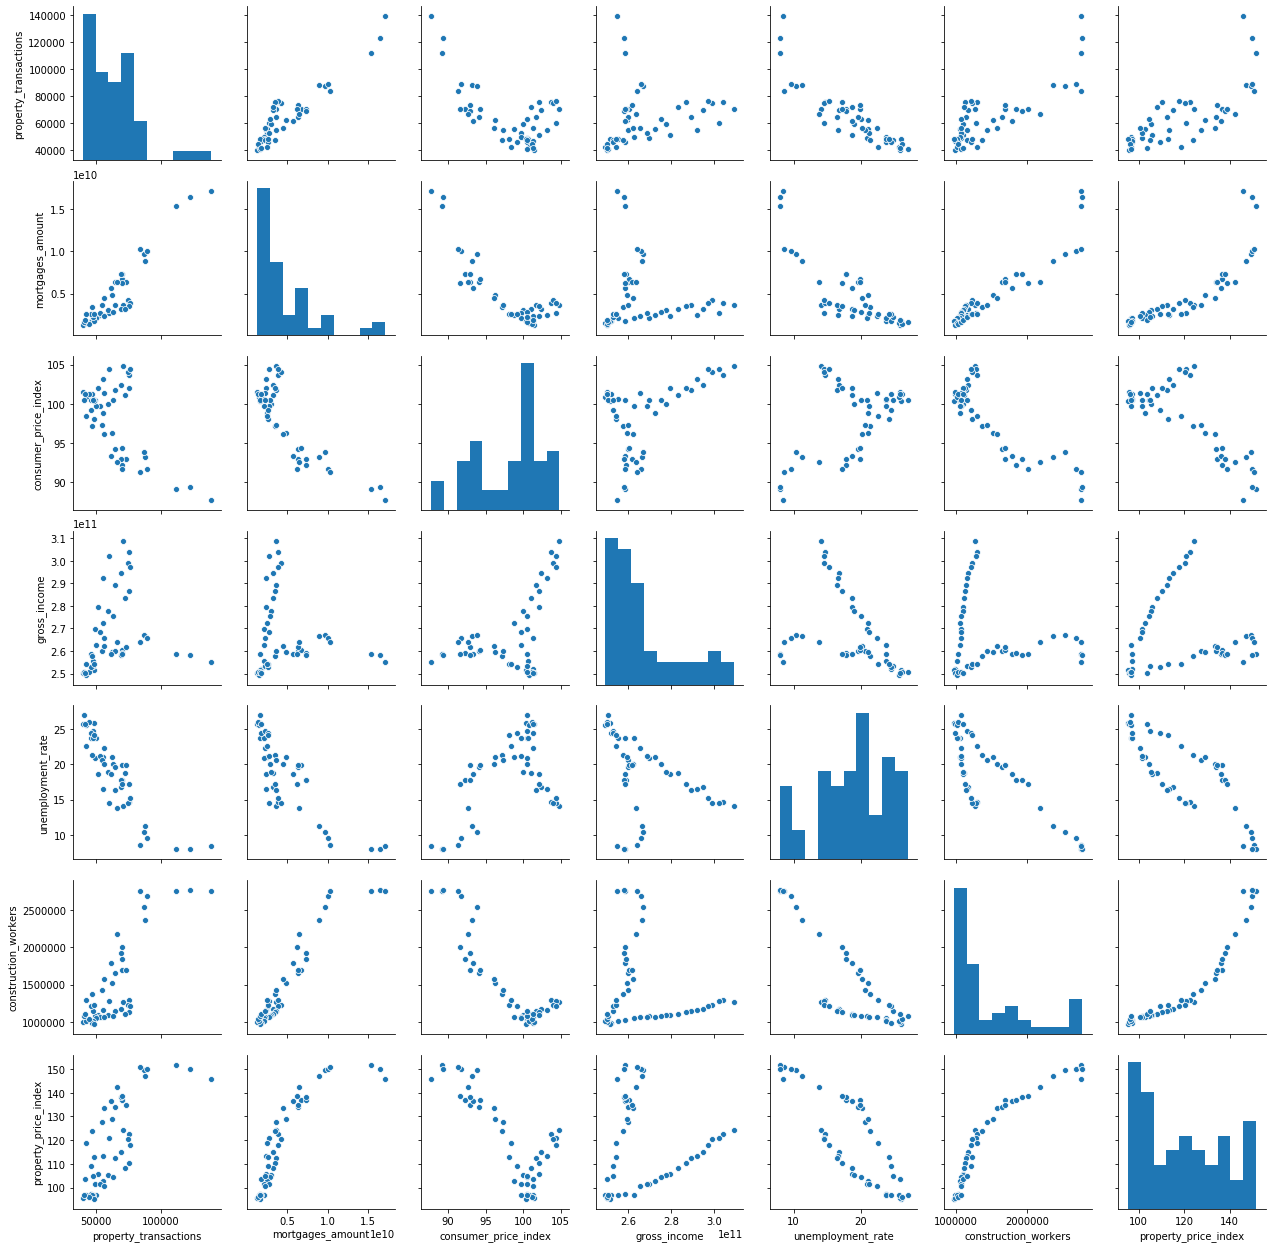

In [9]:
sns.pairplot(data)

Aquí se puede apreciar con claridad y a simple vista como las variables comentadas anteriormente, "property_transactions", "mortgages_amount" y "construction_workers" tienen una alta relación lineal con "property_price_index", siendo "construction_workers" la más destacada de estas 3 caracteristicas por lo que esta variable seguramente sea muy importante en la aplicación de los futuros modelos. De esto se deduce que estas tres características no deberían coexistir al mismo tiempo en la construcción de los futuros modelos. Seguramente la variable elegida de entre las 3 mencionadas sea "construction_workers" ya que vimos en la matriz de correlación que es esta variable la más relacionada con la variable de salida.

Aquí también podemos ver porque la variable "gross_income" no tiene ninguna relación lineal con la variable de salida.


ACCIONES A TOMAR:

En un principio se plantea:

- Eliminar "gross_income" por su poca relación lineal con la variable de salida.
- Eliminar "property_transactions" y "mortgages_amount" por su alta relación con "construction_workers".

#### Cálculo de outliers o valores anómalos 

Un análisis interesante para aquellas características numéricas es comprobar la existencia de valores anómalos o outliers, que son aquellos valores ubicados en posiciones extrañamente altas o bajas dentro del dominio de una variable.


Es este caso podemos utilizar una técnica simple y rápida que utiliza el IQR (Interquartile Ranges), en la que podemos aumentar o disminuir el nivel de restricción por el que un valor puede ser considerado anómalo mediante un factor multiplicativo V. Un valor de V igual a "1.5" será suficiente para calcular todos los outliers más obvios, mientras que, si queremos bajar el nivel de restricción y calcular solo aquellos outliers más extremos, podremos usar un valor de "3" para dicho factor V.

En este caso se ha optado por utilizar un valor de "1.5".

In [10]:
def intercuartil(data, valor=1.5):
  
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound  = Q1 - valor*IQR
    upper_bound  = Q3 + valor*IQR
    print (upper_bound)
    
    outliers = data.copy()
    for col in np.arange(data.shape[1]):
        outliers.iloc[:,col] = (data.iloc[:,col] < lower_bound[col]) | (data.iloc[:,col] > upper_bound[col])
        
    return outliers

outliers = intercuartil(data, 1.5)
outliers.sum()

property_transactions    1.068885e+05
mortgages_amount         1.232430e+10
consumer_price_index     1.123000e+02
gross_income             3.024436e+11
unemployment_rate        3.514875e+01
construction_workers     2.619012e+06
property_price_index     1.852589e+02
dtype: float64


property_transactions    3
mortgages_amount         3
consumer_price_index     0
gross_income             2
unemployment_rate        0
construction_workers     5
property_price_index     0
dtype: int64

Mediante IQR hemos detectado varios outliers dentro de este dataset y bajo que característica o variable se encuentra cada uno de ellos. Veremos ahora en que instancias se encuentran cada uno de ellos mediante el siguiente código:

In [11]:
var = np.unique(np.where(outliers)[1])
for v in var:
    print("**" + data.columns[v] + "**" +" tiene outliers en las instancias: ", end = '')
    print (np.where(outliers)[0][np.where(outliers)[1] == v])


**property_transactions** tiene outliers en las instancias: [47 48 49]
**mortgages_amount** tiene outliers en las instancias: [47 48 49]
**gross_income** tiene outliers en las instancias: [0 1]
**construction_workers** tiene outliers en las instancias: [45 46 47 48 49]


De esta forma hemos detectado cuales son las instancias que poseen valores anómalos y en que característica se encuentra dicho valor. Para resumir, con el siguiente código tendremos todas las instancias y todas las características en las que hay al menos un valor anómalo.

In [12]:
def out_col(outlierBollMatrix):
    return data.columns[np.unique(np.where(outlierBollMatrix)[1])].values

out_col = out_col(outliers)
print ("Características con valores anómalos")
print (out_col)

Características con valores anómalos
['property_transactions' 'mortgages_amount' 'gross_income'
 'construction_workers']


In [13]:
def out_index(outlierBollMatrix):
    return np.unique(np.where(outlierBollMatrix)[0])

out_ind = out_index(outliers)
print ("Instancias con valores anómalos")
print (out_ind)

Instancias con valores anómalos
[ 0  1 45 46 47 48 49]


In [14]:
outliers

,property_transactions,mortgages_amount,consumer_price_index,gross_income,unemployment_rate,construction_workers,property_price_index
0,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False


Estos valores anómalos pueden afectar al desempeño de los algoritmos que utilicemos posteriormente, así que tendremos que decidir qué hacer con ellos.

ACCIONES A TOMAR:

Normalmente deberíamos eliminarlos o modificarlos para volverlos a integrar de forma más útil dentro del dominio de las variables, pero debido al escaso número de instancias y a la posible pérdida de información si hacemos algo de esto, no tomaremos una decisión en este momento, sino que seguiremos realizando un análisis de los datos. 

Cabe destacar que este método de detección de outliers es un procedimiento 1-dimensional, es decir, que solo detectará aquellos valores de una característica que por si mismos constituyen un valor anómalo. Pero existe la posibilidad de que existan outliers n-dimensionales, lo cual quiere decir que una instancia puede ser considerada outlier no por el valor de una sola característica, sino por una combinación extraña de valores en varias características.

En este caso, por el reducido número de características e instancias no se considera necesaria la aplicación de estas técnicas.

#### Análisis de la distribución de las variables

En los siguientes gráficos podemos ver un histograma y una curva de distribución de todas las variables, en azul estarán las variables de entrada y en rojo la de salida.

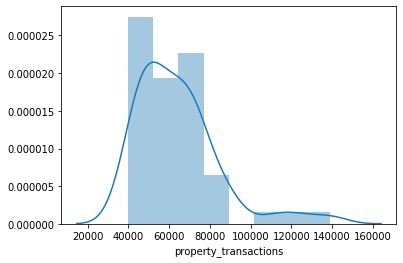

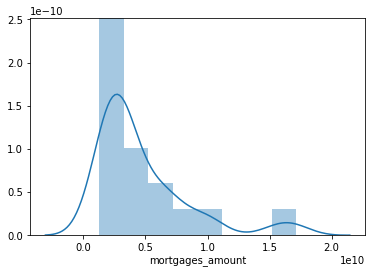

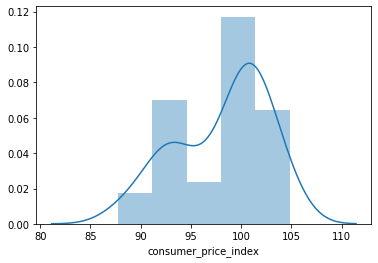

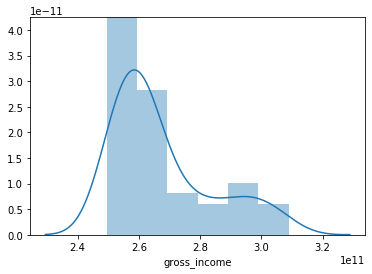

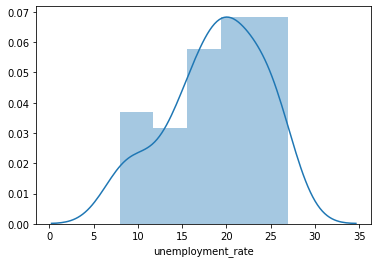

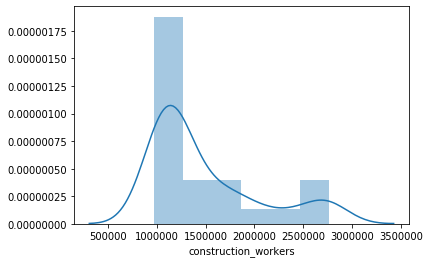

In [15]:
for col in data.columns[:-1]:
    sns.distplot(data[col])
    plt.show()

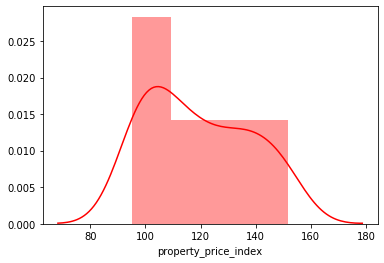

In [16]:
sns.distplot(data[data.columns[-1]], color = 'r')
plt.show()

Podemos ver que ninguna de las variables sigue una distribución normal clara y presentan cierto sesgo a derecha o izquierda. Esto puede estar debido a diversos motivos, entre otros a que solo contamos con 50 instancias en los datos y no es suficiente para sacar conclusiones robustas sobre la distribución de los datos. 

Por otro lado, también es posible que haya algún factor que esté influyendo en los valores de las variables, como por ejemplo el factor tiempo. En la descripción de este problema se comentaba que los datos estaban ordenados cronológicamente, por lo que se deduce que estos datos provienen de diferentes momentos en el tiempo. Este hecho podría estar afectando a los datos de alguna forma si existiere algún tipo de tendencia en los datos a lo largo del tiempo en el que han sido recabados.

*ACCIONES A TOMAR:*

Podría plantearse realizar alguna transformación en los datos, pero en un principio se ha decidido no realizar ninguna debido a la escasez de instancias y a que no existe una previsión de mejora.

#### Análisis de la evolución de las características en el tiempo

En la descripción del problema, se comenta que los datos están ordenados de forma cronológica, así que pintaremos unas gráficas con la evolución de los datos a lo largo del tiempo, y veremos si podemos sacar alguna conclusión interesante.

En azul se verán las variables de entrada y en rojo las variables de salida.

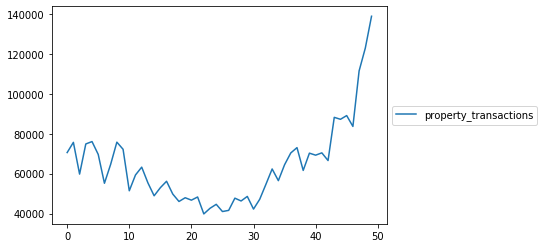

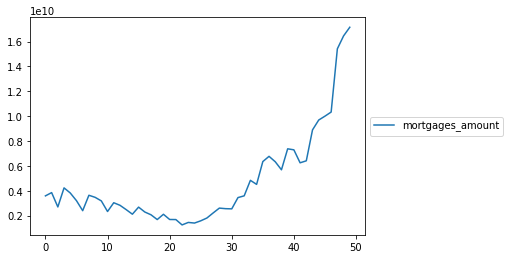

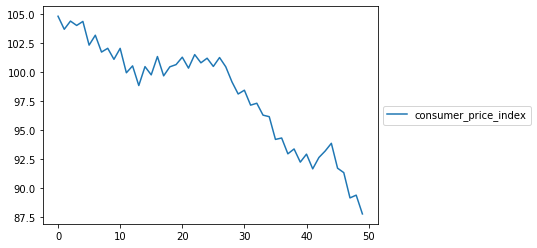

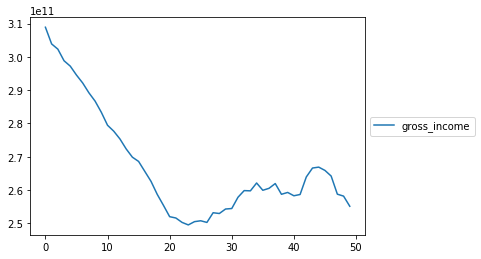

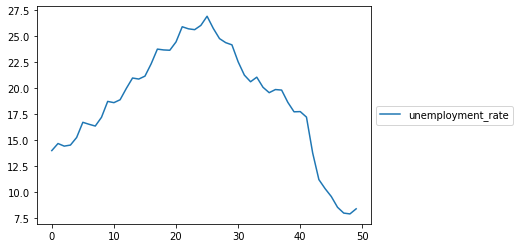

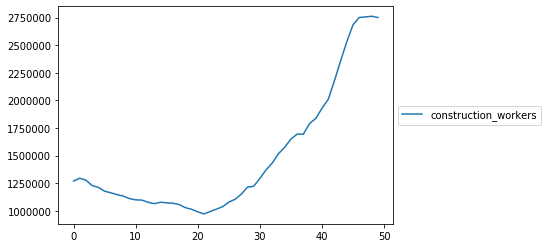

In [17]:
#primera gráfica general
indexs = data.index.values
for col in np.arange(data.iloc[:,:-1].shape[1]):
    plt.plot(indexs, data.iloc[:,col])
    plt.legend([data.columns[col]], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


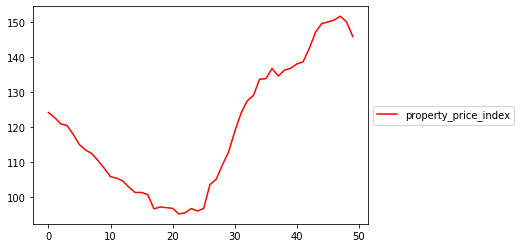

In [18]:
plt.plot(indexs, data.iloc[:,-1], 'r')
plt.legend([data.columns[-1]], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Vemos que muchas de ellas poseen variaciones muy llamativas a lo largo del tiempo que en un principio no parecen ser una cuestión de azar, pero con la escasez de datos no se plantea aplicar ningún método en este sentido.


*ACCIONES A TOMAR:*

No se realizará ninguna modificación ni transformación de los datos en este planteamiento, trabajaremos con los valores iniciales de los datos y su distribuciones sin llegar a modificar nada.

#### Resumen análisis y preprocesamiento de los datos

Tras las pruebas realizadas, podemos destacar las siguientes observaciones y planteamientos:

 - El dataset cuenta con 50 instancias, 6 características de entrada y solo una de salida (todas numéricas)
 - El Dataset no cuenta con valores perdidos.
 - Se han detectado altas dependencias lineales entre algunas variables de entrada (mayor al 80%) y se plantea su eliminación.
 - Se han detectado bajas dependencias lineales entre algunas variables de entrada y la variable de salida y se plantea su eliminación.
 - Se han detectado algunos outliers 1-dimensionales. Por la escasez de datos se ha decidido no eliminar las instancias que contienen dichos outliers.

## Aplicación de modelos.

Para aplicar los modelos comenzaremos por dividir el dataset en los conjuntos de entrenamiento y test. Con tan solo 50 instancias debemos elegir bien como realizamos esta división para que haya suficientes instancias para entrenar, y al mismo tiempo, un conjunto de test lo suficientemente extenso como para poder validar un modelo mediante las pruebas de precisión. En este caso se ha optado una clásica división del 80% para entrenamiento y 20% para test. Esto nos deja 40 instancias en Train y 10 instancias en Test.

Es importante destacar también, que los datos están ordenados de forma cronológica, y se considera interesante la opción de entrenar con los datos disponibles más antiguos e intentar predecir los últimos datos obtenidos ya que se espera esta forma de funcionar en la mayoría de los problemas realas, por lo que la partición del dataset ha de hacerse de forma ordenada y no aleatoria.

Esta partición se consigue de la siguiente forma.


In [109]:
data = pd.read_csv("dataset.csv")
dataX = data.iloc[:,0:-1].copy()
dataY = data.iloc[:,-1].to_frame().copy()
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)

Para intentar predecirla variable de salida en este problema de inferencia, podemos aplicar numerosos algoritmos de diferentes naturalezas. Para poder evaluar y comparar la precisión de estos métodos utilizaremos la métrica de rmse (root mean square error).

In [20]:
def rmse(actual_y, pred_y):
    return sqrt(mse(actual_y, pred_y))

Normalmente existen dos objetivos a la hora de elegir que modelo debemos aplicar. Uno de ellos es la precisión, por lo que será mejor alquel modelo que mejor resultado obtenga, pero al mismo tiempo, puede existeir una necesidad de encontrar un modelo facilmente interpretable, y por tanto, aun cuando un modelo no obtiene el mejor resultado puede ser la mejor opción si cumple exitosamente la exisgencias de interpretabilidad.

Por este motivo comenzaremos a aplciar algunos modelos simples de regresión utilizando la librería de "statsmodels".

### Regresión lineal

In [110]:
#Se crea el modelo de regreión lineal múltiple.
lnrRgrModel_1 = sm.OLS(yTrain, xTrain)
lnrRgrModel_1 = lnrRgrModel_1.fit()

predTrain_lm1 = lnrRgrModel_1.predict(xTrain)
predTest_lm1 = lnrRgrModel_1.predict(xTest)

rmseTrain_lm1 = rmse(yTrain, predTrain_lm1)
rmseTest_lm1 = rmse(yTest, predTest_lm1)

rmseTrain_lm1, rmseTest_lm1

(2.559854989095245, 41.08785729318296)

En este caso vemos una gran diferencia entre el rmse en entrenamiento y el de test, lo que claramente significa que el modelo ha sobreentrenado mucho. Lo cual es comprensible debido a la poca cantidad de datos y la relación lineal de las variables.

R-squared es una medida que nos puede indicar como de bien se ajustan nuestras variables al modelo en la regresión realizada, cuanto más cercada esté a 1 quiere decir los regresores utilizados explican mejor el modelo. Es importante utilizar el Adjusted "R-Squared Ajustado" en lugar de simplemente "R-squared" para eliminar la influencia del número de regresores utilizados.

Para ver este dato y muchos otros interesantes, podemos imprimir un resumen del modelo entrenado.

In [22]:
lnrRgrModel_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     property_price_index   R-squared (uncentered):                   0.999
Model:                              OLS   Adj. R-squared (uncentered):              0.999
Method:                   Least Squares   F-statistic:                          1.109e+04
Date:                  Sun, 17 Nov 2019   Prob (F-statistic):                    1.87e-54
Time:                          19:21:22   Log-Likelihood:                         -94.356
No. Observations:                    40   AIC:                                      200.7
Df Residuals:                        34   BIC:                                      210.8
Df Model:                             6                                                  
Covariance Type:              nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
property_transactions  5.026e-05      0.000      0.374      0.711      -0.000       0.000
mortgages_amount      -1.589e-09   1.58e-09     -1.003      0.323   -4.81e-09    1.63e-09
consumer_price_index      0.5885      0.432      1.363      0.182      -0.289       1.466
gross_income           -2.05e-11   1.39e-10     -0.148      0.883   -3.03e-10    2.62e-10
unemployment_rate        -0.8622      0.437     -1.972      0.057      -1.751       0.027
construction_workers   6.428e-05   7.07e-06      9.091      0.000    4.99e-05    7.87e-05
==============================================================================
Omnibus:                        2.469   Durbin-Watson:                   0.668
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.409
Skew:                          -0.374   Prob(JB):                        0.494
Kurtosis:                       3.534   Cond. No.                     3.72e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que "Adj. R-squared" es: 0.99 lo cual quiere decir que el modelo se ha podido ajustar aceptablemente bien y por eso ha obtenido un error muy bajo en entrenamiento, pero este modelo no es válido al haberse sobre ajustado a los datos de entrenamiento y no generalizar bien en test.

Otro dato destacable es que "Cond. No." es: 3.72e+11, lo cual quiere decir que existen marcada multicolinealidad entre las variables, como ya vimos en cuando analizamos las relaciones lineales entre las variables.

Para ver que variables han sido menos importantes en la construcción del modelo, podemos observar su valer de p-value y descartas aquellas variables con un valor superior.

In [23]:
p_values = pd.Series.to_frame( lnrRgrModel_1.summary2().tables[1]['P>|t|']).round(4)
print (p_values)

                        P>|t|
property_transactions  0.7107
mortgages_amount       0.3230
consumer_price_index   0.1818
gross_income           0.8834
unemployment_rate      0.0568
construction_workers   0.0000


De estos datos podemos concluir que la variable más importante es "construction_workers" y que algunas de las menos importantes son 'gross_income', 'property_transactions' y 'mortgages_amount' como ya intuimos anteriormente cuando analizamos las relaciones lineales entre las variables.

Así pues, teniendo en cuenta el resultado de este modelo, se ha decidido eliminar dichas variables.

In [112]:
deleteCol = ['gross_income', 'property_transactions', 'mortgages_amount']
dataX.drop(deleteCol, inplace=True, axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)

Una vez eliminadas, volvemos a entrenar el modelo e intentar predecir la variable de salida

In [113]:
lnrRgrModel_2 = sm.OLS(yTrain, xTrain)
lnrRgrModel_2 = lnrRgrModel_2.fit()
predTrain_lm2 = lnrRgrModel_2.predict(xTrain)
predTest_lm2 = lnrRgrModel_2.predict(xTest)

rmseTrain_lm2 = rmse(yTrain, predTrain_lm2)
rmseTest_lm2 = rmse(yTest, predTest_lm2)

rmseTrain_lm2, rmseTest_lm2

(2.621386532600454, 40.812132627679446)

In [26]:
lnrRgrModel_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     property_price_index   R-squared (uncentered):                   0.999
Model:                              OLS   Adj. R-squared (uncentered):              0.999
Method:                   Least Squares   F-statistic:                          2.301e+04
Date:                  Sun, 17 Nov 2019   Prob (F-statistic):                    1.51e-60
Time:                          19:21:22   Log-Likelihood:                         -95.306
No. Observations:                    40   AIC:                                      196.6
Df Residuals:                        37   BIC:                                      201.7
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
consumer_price_index     0.5841      0.033     17.564      0.000       0.517       0.651
unemployment_rate       -0.7441      0.113     -6.597      0.000      -0.973      -0.516
construction_workers  5.641e-05   1.65e-06     34.285      0.000    5.31e-05    5.97e-05
==============================================================================
Omnibus:                        2.256   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.316
Skew:                          -0.067   Prob(JB):                        0.518
Kurtosis:                       3.878   Cond. No.                     3.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos como después de este cambio, apenas existe una mejora en el error de test, por lo que no hemos conseguido mucho.

Visto que el mayor problema no es la correlaciones entre las variables de entrada, sino que el modelo se sobreajusta al conjunto de entrenamiento, vamos a proceder a introducir algunas variables al modelo para hacerlo más potente y dotarlo de recursos para que consiga un mejor resultado. Para ello introduciremos el cuadrado de la variable más importante en el modelo "construction_workers" y alguna combinación de variables que parezca interesante. 

In [80]:
dataX['construction_workerss^2'] = dataX['construction_workers'] ** 2
dataX['new'] = dataX['construction_workers'] * dataX['unemployment_rate']
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)

In [82]:
lnrRgrModel_3 = sm.OLS(yTrain, xTrain)
lnrRgrModel_3 = lnrRgrModel_3.fit()
predTrain_lm3 = lnrRgrModel_3.predict(xTrain)
predTest_lm3 = lnrRgrModel_3.predict(xTest)

rmseTrain_lm3 = rmse(yTrain, predTrain_lm3)
rmseTest_lm3 = rmse(yTest, predTest_lm3)

rmseTrain_lm3, rmseTest_lm3

(1.6174463549379146, 29.559310396004193)

Ahora si vemos una mejoría considerable en el conjunto de test, analicemos el modelo generado.

In [29]:
lnrRgrModel_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     property_price_index   R-squared:                       0.986
Model:                              OLS   Adj. R-squared:                  0.984
Method:                   Least Squares   F-statistic:                     607.0
Date:                  Sun, 17 Nov 2019   Prob (F-statistic):           8.55e-32
Time:                          19:21:22   Log-Likelihood:                -75.991
No. Observations:                    40   AIC:                             162.0
Df Residuals:                        35   BIC:                             170.4
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
consumer_price_index        0.0971      0.368      0.264      0.793      -0.649       0.844
unemployment_rate          -1.6756      1.176     -1.424      0.163      -4.064       0.713
construction_workers        0.0001   4.67e-05      3.127      0.004    5.13e-05       0.000
construction_workerss^2 -4.048e-11   1.13e-11     -3.585      0.001   -6.34e-11   -1.76e-11
new                      8.349e-07   1.12e-06      0.744      0.462   -1.44e-06    3.11e-06
==============================================================================
Omnibus:                        0.200   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.338
Skew:                           0.146   Prob(JB):                        0.845
Kurtosis:                       2.658   Cond. No.                     7.65e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.65e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Si nos fijamos en los coeficientes que el modelo ha ajustado, ahora la variable "construction_workers" apenas tiene influencia, por lo que podemos intentar eliminarla y observar el resultado

In [84]:
dataX.drop('construction_workers', inplace=True, axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)

In [85]:
lnrRgrModel_4 = sm.OLS(yTrain, xTrain)
lnrRgrModel_4 = lnrRgrModel_4.fit()
predTrain_lm4 = lnrRgrModel_4.predict(xTrain)
predTest_lm4 = lnrRgrModel_4.predict(xTest)

rmseTrain_lm4 = rmse(yTrain, predTrain_lm4)
rmseTest_lm4 = rmse(yTest, predTest_lm4)

rmseTrain_lm4, rmseTest_lm4

(1.829538292810434, 23.98363501096101)

In [32]:
lnrRgrModel_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     property_price_index   R-squared:                       0.982
Model:                              OLS   Adj. R-squared:                  0.980
Method:                   Least Squares   F-statistic:                     648.0
Date:                  Sun, 17 Nov 2019   Prob (F-statistic):           2.28e-31
Time:                          19:21:22   Log-Likelihood:                -80.920
No. Observations:                    40   AIC:                             169.8
Df Residuals:                        36   BIC:                             176.6
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
consumer_price_index        1.2422      0.038     32.959      0.000       1.166       1.319
unemployment_rate          -5.1089      0.472    -10.834      0.000      -6.065      -4.152
construction_workerss^2 -6.169e-12   2.98e-12     -2.071      0.046   -1.22e-11   -1.28e-13
new                      4.123e-06   4.37e-07      9.433      0.000    3.24e-06    5.01e-06
==============================================================================
Omnibus:                        0.906   Durbin-Watson:                   1.244
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.835
Skew:                           0.329   Prob(JB):                        0.659
Kurtosis:                       2.741   Cond. No.                     2.64e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

En este caso hemos conseguido bajar más aún el error de test.

*ACLARACIÓN:*

Aunque en este último modelo se ha obtenido un error más bajo, hay que tener en cuenta que realmente contamos con un conjunto de pruebas muy reducido (tan solo 10 instancias), por lo que esta mejora puede no significar un mejor modelo cuando se utilice con datos futuros. sería necesario analizar con alguna prueba más robusta cuál de estos dos últimos modelos es más acertado.

En estos casos, el modelo es altamente interpretable ya que podemos sabes con claridad cual es el coeficiente multiplicativo de cada variable de entrada para calcular la variable de salida, por lo que en todo momento sabremos a que se debe la predicción realizada.


A continuación podemos ver como se ha ajustado los dos ultimos modelos tanto en entrenamiento como en test:

Gráfica para el tercer modelo de regresión:

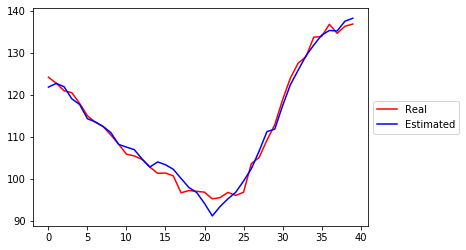

In [33]:
plt.plot(np.arange(yTrain.size), yTrain, 'r')
plt.plot(np.arange(yTrain.size), predTrain_lm3, 'b')
plt.legend(['Real', 'Estimated'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

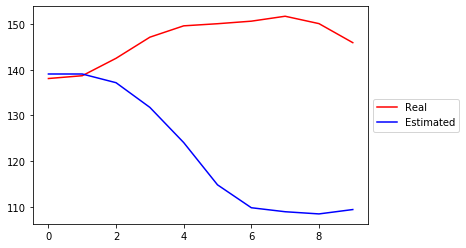

In [34]:
plt.plot(np.arange(yTest.size), yTest, 'r')
plt.plot(np.arange(yTest.size), predTest_lm3, 'b')
plt.legend(['Real', 'Estimated'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Gráfica para el cuarto modelo de regresión:

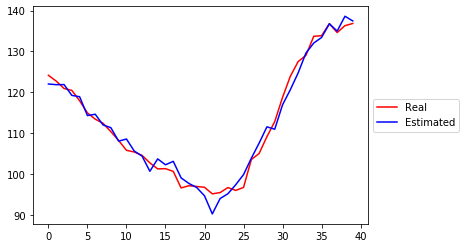

In [35]:
plt.plot(np.arange(yTrain.size), yTrain, 'r')
plt.plot(np.arange(yTrain.size), predTrain_lm4, 'b')
plt.legend(['Real', 'Estimated'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

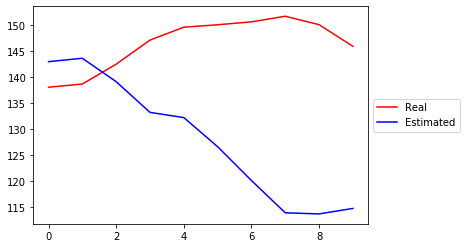

In [36]:
plt.plot(np.arange(yTest.size), yTest, 'r')
plt.plot(np.arange(yTest.size), predTest_lm4, 'b')
plt.legend(['Real', 'Estimated'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Vemos claramente como existe un claro sobreajuste al conjunto de entrenamiento en ambos modelos y que en test los errores se incrementan. Ninguno de los modelos aquí mostrados obtiene valores especialmente buenos, pero por otro lado son modelos simples y altamente interpretables, por lo que en algunos casos pueden llegar a ser de mucho interés.

### Regresión Lasso

La regresión Lasso es un tipo de regresión algo diferente a la regresión lineal, ya que no solo minimiza el error cuadrático, sino que aplica una penalización a los coeficientes. Este tipo de regresión, entre otras cosas, es más robusta ante outliers y puede prevenir el sobreentrenamiento.

Además, Lasso cuenta con una optimización de parámetros iterativa para encontrar el mejor modelo en base a los parámetros que utilicemos. 

In [87]:
dataX = data.iloc[:,0:-1].copy()
dataY = data.iloc[:,-1].to_frame().copy()

In [88]:
scaler = preprocessing.StandardScaler()
trans_x = scaler.fit_transform(dataX)
xTrain, xTest, yTrain, yTest = train_test_split(trans_x, dataY, test_size = 0.2, shuffle=False, random_state = 6)

In [89]:
model_Lasso = Lasso(alpha = 2.6, random_state=6).fit(xTrain, yTrain)

predTrain_lasso = model_Lasso.predict(xTrain)
predTest_lasso = model_Lasso.predict(xTest)

rmse(yTrain, predTrain_lasso), rmse(yTest, predTest_lasso)

(6.9657401021767855, 6.15841812315892)

Como vemos, el modelo generado obtiene un error mucho más bajo que los modelos anteriores. Analicemos también los coeficientes que las iteraciones de Lasso ha encontrado:

In [40]:
model_Lasso.coef_

array([ 0.        ,  0.        , -0.        ,  0.        , -2.9429506 ,
       13.95723665])

Curiosamente, existen varias variables con un coeficiente igual a cero, por lo que su influencia en el modelo es nula.

Veamos cuales son las dos únicas variables que influyen en el modelo.

In [90]:
dataX.columns[np.where(model_Lasso.coef_ != 0)]

Index(['unemployment_rate', 'construction_workers'], dtype='object')

Así pues, obtenemos que las dos variables que más influyen en el modelo son 'unemployment_rate' y una vez más 'construction_workers'.

A continuación eliminaremos todas las variables que no influyen en el modelo y volveremos a realizar una estimación mediante una regresión Lasso.

In [91]:
cc = dataX.columns[np.where(model_Lasso.coef_ == 0)]
dataX.drop(cc, inplace=True, axis=1)

scaler = preprocessing.StandardScaler()
dataX = scaler.fit_transform(dataX)
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)

model_Lasso = Lasso(alpha = 2.6, random_state=6).fit(xTrain, yTrain)

predTrain_lasso = model_Lasso.predict(xTrain)
predTest_lasso = model_Lasso.predict(xTest)

rmseTrain_lasso = rmse(yTrain, predTrain_lasso)
rmseTest_lasso = rmse(yTest, predTest_lasso)

rmseTrain_lasso, rmseTest_lasso

(6.965725843399652, 6.158461191728749)

Como era de esperar, al eliminar las variables con influencia nula el resultado obtenido es el mismo, pero el modelo obtenido realmente es más simple, dado que no es necesario asignar coeficientes iguales a cero a las variables eliminadas.

Si analizamos el ajuste del modelo mediante los siguientes gráficos, observamos que no existe un sobreajuste en el conjunto de entrenamiento y eso le ayuda a generalizar mejor cuando intenta estimar en el conjunto de test.

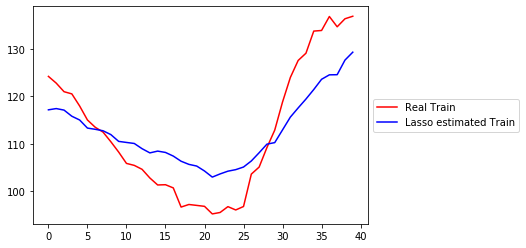

In [92]:
plt.plot(np.arange(yTrain.size), yTrain, 'r')
plt.plot(np.arange(yTrain.size), predTrain_lasso, 'b')
plt.legend(['Real Train', 'Lasso estimated Train'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

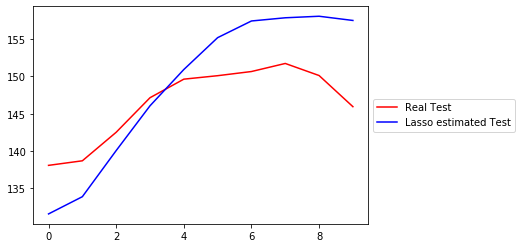

In [93]:
plt.plot(np.arange(yTest.size), yTest, 'r')
plt.plot(np.arange(yTest.size), predTest_lasso, 'b')
plt.legend(['Real Test', 'Lasso estimated Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Regresión Ridge

La regresión Ridge al igual que la Lasso no solo intenta minimizar el error cuadrático, sino que penaliza los coeficientes de las variables y es robusta ente ruido y outliers, as



In [94]:
dataX = data.iloc[:,0:-1].copy()
dataY = data.iloc[:,-1].to_frame().copy()
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)

Para esta regresión además, utilizaremos el selector de características RFE de la librería sklearn.

Si intentamos seleccionar la mitad de las variables obtendríamos el siguiente ranking:

In [95]:
estimator = Ridge(alpha=3.1, normalize=True)
selector = RFE(estimator, 3)
selector = selector.fit(xTrain, yTrain.values.ravel())
print(selector.ranking_)

[1 3 1 4 1 2]


Donde 1 significa que la importancia de la variable es máxima y cuanto mayor sea el número, menor será la importancia de su correspondiente característica para el modelo.

En ese caso se ha decidido eliminar solo la variable de menor importancia y dejar el resto.

In [96]:
estimator = Ridge(alpha=3.1, normalize=True)
selector = RFE(estimator, 5)
selector = selector.fit(xTrain, yTrain.values.ravel())
print(selector.ranking_)
print ("La Variable menos influyente es: '" + dataX.columns[~selector.support_][0] + "'")

[1 1 1 2 1 1]
La Variable menos influyente es: 'gross_income'


Se ha obtenido que la característica menos importante es 'gross_income' y la eliminaremos a continuación.

In [97]:
dataX = data.iloc[:,0:-1].copy()
dataY = data.iloc[:,-1].to_frame().copy()
cc = dataX.columns[~selector.support_]
dataX.drop(cc, inplace=True, axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)
dataX.shape

(50, 5)

Una vez eliminada la característica menos influyente, realalizaremos el ajuste de la regresión Ridge activando la normalización interna del algoritmo. 

In [99]:
model_Ridge = Ridge(alpha=3.1, normalize=True)
model_Ridge.fit(xTrain, yTrain) 
predTrain_Ridge = model_Ridge.predict(xTrain)
predTest_Ridge = model_Ridge.predict(xTest)

rmseTrain_Ridge = rmse(yTrain, predTrain_Ridge)
rmseTest_Ridge = rmse(yTest, predTest_Ridge)

rmseTrain_Ridge, rmseTest_Ridge

(7.91822507202694, 8.956603075719446)

Con la regresión de Ridge también obtenemos un error en test considerablemente bajo sin llegar a sobreajustar en el conjunto de train ya que los errores obtenidos en estos dos conjuntos son muy parecidos.

Este hecho también lo podemos ver en los gráficos de ajuste que se muestran a continuación:

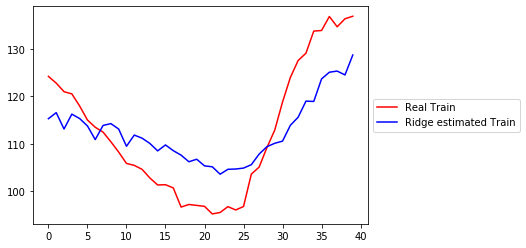

In [50]:
plt.plot(np.arange(yTrain.size), yTrain, 'r')
plt.plot(np.arange(yTrain.size), predTrain_Ridge, 'b')
plt.legend(['Real Train', 'Ridge estimated Train'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

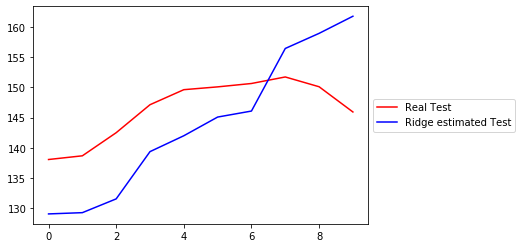

In [51]:
plt.plot(np.arange(yTest.size), yTest, 'r')
plt.plot(np.arange(yTest.size), predTest_Ridge, 'b')
plt.legend(['Real Test', 'Ridge estimated Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Áboles de decisión - Random Forest

Por ultimo probaremos una técnica diferente a la regresión con gran poder de ajuste y con controles que permiten ajustarse al sobrentrenamiento o incluso outliers como son los árboles de decisión y más concretamente Random Forest

In [52]:
dataX = data.iloc[:,0:-1].copy()
dataY = data.iloc[:,-1].to_frame().copy()
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)
dataX.shape

(50, 6)

Para Random Forest también utilizaremos un selector de características RFE. En este caso vamos a ver el ranking de importancia de características si tan solo escogemos una variable:

In [53]:
estimator =  RandomForestRegressor(max_depth=4, n_estimators=300, min_samples_leaf=2, random_state=0)
selector = RFE(estimator, 1)
selector = selector.fit(xTrain, yTrain.values.ravel())
print(selector.ranking_)
print ("La Variable más influyente es: '" + dataX.columns[selector.support_][0] + "'")

[6 2 3 4 5 1]
La Variable más influyente es: 'construction_workers'


Ante este ranking se plantean dos actuaciones: 
- Aceptar hasta un indice de importancia 3 en el ranking, lo que implica quedarse con 3 variables.
- Escoger solo la variable más influente y descartar el resto.

Con 3 variables obtendriamos el siguiente modelo:

In [54]:
cc = dataX.columns[np.where(selector.ranking_>3)]
dataX.drop(cc, inplace=True, axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)
dataX.columns

Index(['mortgages_amount', 'consumer_price_index', 'construction_workers'], dtype='object')

In [55]:
rf = RandomForestRegressor(max_depth=5, n_estimators=100, min_samples_leaf=1, random_state=6, criterion="mae").fit(xTrain, yTrain.values.ravel())
predTrain_RF = rf.predict(xTrain)
predTest_RF = rf.predict(xTest)
rmse(yTrain, predTrain_RF), rmse(yTest, predTest_RF)

(1.0947319347259108, 11.075029527661126)

Ahora probaremos con tan solo una característica

In [56]:
dataX = data.iloc[:,0:-1].copy()
cc = dataX.columns[np.where(selector.ranking_>1)]
dataX.drop(cc, inplace=True, axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(dataX, dataY, test_size = 0.2, shuffle=False, random_state = 6)
dataX.columns

Index(['construction_workers'], dtype='object')

La característica más influyente es 'construction_workers'

In [57]:
rf = RandomForestRegressor(max_depth=5, n_estimators=100, min_samples_leaf=1, criterion="mae", random_state=6).fit(xTrain, yTrain.values.ravel())
predTrain_RF = rf.predict(xTrain)
predTest_RF = rf.predict(xTest)
rmse(yTrain, predTrain_RF), rmse(yTest, predTest_RF)

(1.5064253881708232, 11.01499292385165)

Obtenemos exactamente el mismo resultado para 3 características que para una sola, esto quiere decir que Random Forest utiliza simplemente 'construction_workers' para predecir.

Una vez más vemos como el error en entrenamiento es mucho más bajo que en test, por lo que se deduce que ha habido un sobreajuste al conjunto de entrenamiento. Lo veremos más claramente con las siguientes gráficas: 

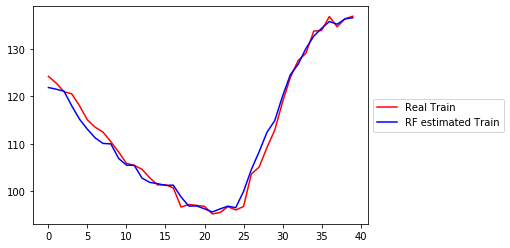

In [58]:
plt.plot(np.arange(yTrain.size), yTrain, 'r')
plt.plot(np.arange(yTrain.size), predTrain_RF, 'b')
plt.legend(['Real Train', 'RF estimated Train'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

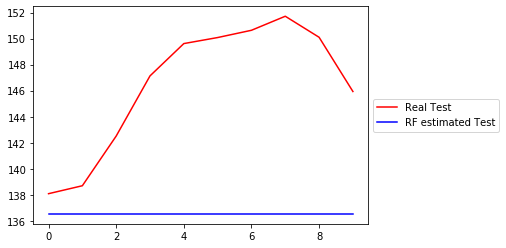

In [59]:
plt.plot(np.arange(yTest.size), yTest, 'r')
plt.plot(np.arange(yTest.size), predTest_RF, 'b')
plt.legend(['Real Test', 'RF estimated Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Claramente vemos como Random Forest ha sobreentrenado claramente.

Además ocurre algo realmente interesante, la salida para todo el conjunto de test es exactamente 136.52715 y no varía nada como se ve a continuación.

In [60]:
predTest_RF

array([136.52715, 136.52715, 136.52715, 136.52715, 136.52715, 136.52715,
       136.52715, 136.52715, 136.52715, 136.52715])

Antes de empezar con la explicación de este fenomeno, visualicemos la gráfica de 'construction_workers'.

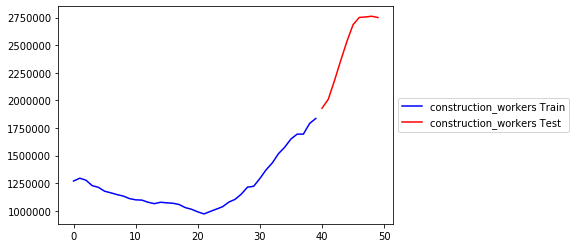

In [61]:
plt.plot(np.arange(40), xTrain['construction_workers'], 'b')
plt.plot(np.arange(40,50), xTest['construction_workers'], 'r')
plt.legend(['construction_workers Train', 'construction_workers Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Esto ocurre por dos motivos principalmente:
- Por un lado, tenemos la forma de funcionar de los árboles de decisión, donde los datos se dividen entre los diferentes nodos del árbol en función del valor de sus variables.
- Por otro lado, los datos del conjunto de test tienen valores superiores a todos los datos de entrenamiento en construction_workers, como se ve en la gráfica anterior.

Esto puede llevar a que Random Forest aprenda lo siguiente:
    
    Si 'construction_workers' es mayor a x -ENTONCES- 'property_price_index' es 136.52715

Esto puede funcionar bien en el conjunto de entrenamiento, donde muy pocos valores son mayores a x, pero en el conjunto de test todos los valores son mayores a este supuesto número x, por lo que Random Forest estima siempre una salida de 136.52715. La solución a esto es hacer una partición de los datos diferente, donde por ejemplo, los datos se distribuyan repartidamente a lo lardo de todo el dataset.

In [100]:
#realiza una pertición de datos repartida por todo el dataset
def distributedSplit(data):
    bollin = np.ones((50), dtype=bool)
    bollin[np.arange(4, 50, 5)] = False
    np.where(bollin == False)
        
    xTrain = data.iloc[bollin,:-1]
    xTest = data.iloc[~bollin,:-1]
        
    yTrain = data.iloc[bollin,-1]
    yTest = data.iloc[~bollin,-1]
    
    return xTrain, xTest, yTrain, yTest

xTrain, xTest, yTrain, yTest = distributedSplit(data)

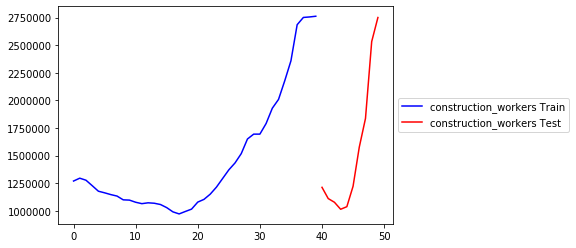

In [101]:
plt.plot(np.arange(40), xTrain['construction_workers'], 'b')
plt.plot(np.arange(40,50), xTest['construction_workers'], 'r')
plt.legend(['construction_workers Train', 'construction_workers Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Con esta nueva partición de datos, será mucho más interesante aplicar un Random Forest para intentar predecir.

In [102]:
rf = RandomForestRegressor(max_depth=5, n_estimators=100, min_samples_leaf=1, random_state=6, criterion="mae").fit(xTrain, yTrain.values.ravel())
predTrain_RF = rf.predict(xTrain)
predTest_RF = rf.predict(xTest)
rmse(yTrain, predTrain_RF), rmse(yTest, predTest_RF)

rmseTrain_RF = rmse(yTrain, predTrain_RF)
rmseTest_RF = rmse(yTest, predTest_RF)

rmseTrain_RF, rmseTest_RF

(0.9088955821228714, 2.56401080830838)

En esta caso hemos obtenido un RMSE igual a **2.564** en test, lo que ciertamente lo combierte en el mejor modelo de todos los aplicados, además, teniendo en cuenta la poca diferencia entre los errorres de entrenamiento y test, no paerece que haya sobreajuste a los datos de entrenamiento, pero esta cuestión se apreciará más facilmente con los siguientes gráficos.

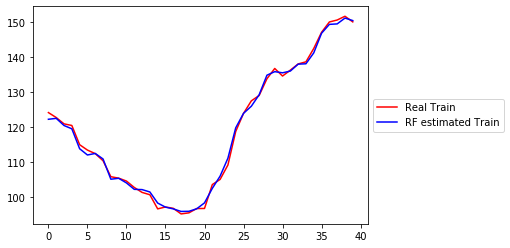

In [103]:
plt.plot(np.arange(yTrain.size), yTrain, 'r')
plt.plot(np.arange(yTrain.size), predTrain_RF, 'b')
plt.legend(['Real Train', 'RF estimated Train'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

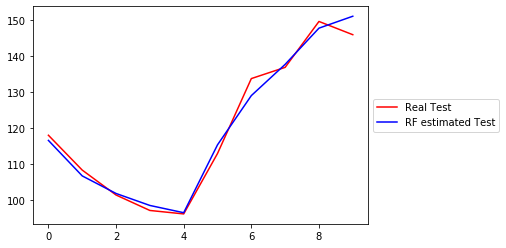

In [104]:
plt.plot(np.arange(yTest.size), yTest, 'r')
plt.plot(np.arange(yTest.size), predTest_RF, 'b')
plt.legend(['Real Test', 'RF estimated Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Finalmente vemos como al particionar los datos de esta forma, el resultado obtenido es significativamente mejor que el anterior y se evita por completo el sobre entrenamiento anterior.

## Conclusión tras el análisis

A lo largo de todo este análisis se han aplicado diferentes modelos, de regresión lineal múltiple, regresión Lasso y Ridge así como árboles de decisión.

Los resultados que se han obtenido son los siguientes:

In [116]:
print("Regresión lineal model_1:")
print("    RMSE de Test Train = " + str(rmseTrain_lm1))
print("    RMSE de Test Test  = " + str(rmseTest_lm1))

print("Regresión lineal model_2:")
print("    RMSE de Test Train = " + str(rmseTrain_lm2))
print("    RMSE de Test Test  = " + str(rmseTest_lm2))

print("Regresión lineal model_3:")
print("    RMSE de Test Train = " + str(rmseTrain_lm3))
print("    RMSE de Test Test  = " + str(rmseTest_lm3))

print("Regresión lineal model_4:")
print("    RMSE de Test Train = " + str(rmseTrain_lm4))
print("    RMSE de Test Test  = " + str(rmseTest_lm4))

print("Regresión Lasso:")
print("    RMSE de Test Train = " + str(rmseTrain_lasso))
print("    RMSE de Test Test  = " + str(rmseTest_lasso))

print("Regresión Ridge:")
print("    RMSE de Test Train = " + str(rmseTrain_Ridge))
print("    RMSE de Test Test  = " + str(rmseTest_Ridge))

print("Regresión Random Forest:")
print("    RMSE de Test Train = " + str(rmseTrain_RF))
print("    RMSE de Test Test  = " + str(rmseTest_RF))

Regresión lineal model_1:
    RMSE de Test Train = 2.559854989095245
    RMSE de Test Test  = 41.08785729318296
Regresión lineal model_2:
    RMSE de Test Train = 2.621386532600454
    RMSE de Test Test  = 40.812132627679446
Regresión lineal model_3:
    RMSE de Test Train = 1.6174463549379146
    RMSE de Test Test  = 29.559310396004193
Regresión lineal model_4:
    RMSE de Test Train = 1.829538292810434
    RMSE de Test Test  = 23.98363501096101
Regresión Lasso:
    RMSE de Test Train = 6.965725843399652
    RMSE de Test Test  = 6.158461191728749
Regresión Ridge:
    RMSE de Test Train = 7.91822507202694
    RMSE de Test Test  = 8.956603075719446
Regresión Random Forest:
    RMSE de Test Train = 0.9088955821228714
    RMSE de Test Test  = 2.56401080830838


Aquí vemos como el mejor modelo encontrado ha sido Random Forest con un rmse en Test de __2.564__, y sin existir un sobreajuste de los datos. Seguidamente se encuentran los modelos de Lasso y Ridge, con un comportamiento y resultados muy parecidos y por ultimo los modelos de regresión lineal.

Aun así, como ya se mencionó anteriormente, no siempre lo más importante es la precisión de un método, sino que muchas veces se vuelve realmente importante la interpretación del modelo. Por este motivo todos los demás modelos de regresión se vuelven verdaderamente interesantes y podrían llegar a sustituir al modelo de Random Forest para este mismo problema según sean las necesidades y los requisitos por cubrir.

Cabe destacar también, que el conjunto de datos solo cuenta con 50 instancias en total que se han repartido siempre en 40  para entrenamiento y 10 para test. Este número tan reducido de instancias puede hacer que las conclusiones sacadas de este estudio cambien ligeramente conforma se vaya incrementando el dataset, y que en un supuesto futuro se deban tomar decisiones diferentes.

Algunas observaciones que se han validado desde el principio del análisis es que la variable más importante del dataset para predecir __'property_price_index'__ es sin ninguna duda __'construction_workers'__ y que la menor de ellas parece ser __'gross_income'__. Teniendo esto en cuenta se podría recabar más información en este sentido de aquí a futuro.